In [167]:
import numpy as np 
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# data reading

In [168]:
# read data and extract wearer names from json file

data_folder = 'eye-tracking data'
wearer_names = {}

folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder))]
for folder in folders:
    info_json_path = os.path.join(data_folder, folder, 'info.json')

    if os.path.exists(info_json_path):
        with open(info_json_path, 'r') as f:
            info_data = json.load(f)
        wearer_name = info_data['wearer_name']
        wearer_names[folder] = wearer_name

dfs = []

for folder in folders:
    events_csv_path = os.path.join(data_folder, folder, 'events.csv')

    if os.path.exists(events_csv_path):
        df = pd.read_csv(events_csv_path)
        wearer_name = wearer_names[folder]
        df['wearer_name'] = wearer_name
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df

,recording id,timestamp [ns],name,type,wearer_name
0,399445b8-e3a1-4816-9d5d-1f7019847862,1695931277593000000,recording.begin,recording,D02-P033
1,399445b8-e3a1-4816-9d5d-1f7019847862,1695931288359403000,phone.pickup,cloud,D02-P033
2,399445b8-e3a1-4816-9d5d-1f7019847862,1695931300460712000,d1.in,cloud,D02-P033
3,399445b8-e3a1-4816-9d5d-1f7019847862,1695931300460712000,matter1.begin,cloud,D02-P033
4,399445b8-e3a1-4816-9d5d-1f7019847862,1695931321216511000,phone.putdown,cloud,D02-P033
...,...,...,...,...,...
2199,adb20035-13c3-41f1-b08d-07c0f338a2a6,1696192433681506000,d6.out,cloud,D01-P064
2200,adb20035-13c3-41f1-b08d-07c0f338a2a6,1696192435749759000,thought1.end,cloud,D01-P064
2201,adb20035-13c3-41f1-b08d-07c0f338a2a6,1696192436945640000,p71.begin,cloud,D01-P064
2202,adb20035-13c3-41f1-b08d-07c0f338a2a6,1696192472771558000,p71.end,cloud,D01-P064


# data cleaning

In [169]:
# Has anyone not passed through any of the doors?
# Apparently, one person has not; upon reviewing the video, the it was accurately detected.

filtered_df = df[df['name'].str.startswith('d', na=False)]
wearer_names_with_d = filtered_df['wearer_name'].unique()
filtered_df_2 = df[~df['wearer_name'].isin(wearer_names_with_d)]
wearer_names_without_d = filtered_df_2['wearer_name'].unique()
wearer_names_without_d

array(['D04-P038'], dtype=object)

In [170]:
# how many unique recrding? how many unique wearers?

unique_recording_ids = df['recording id'].nunique()
print("Number of unique recording ids:", unique_recording_ids)

unique_recording_ids = df['wearer_name'].nunique()
print("Number of unique wearer names:", unique_recording_ids)

Number of unique recording ids: 99
Number of unique wearer names: 95


In [171]:
# Door sequences have been crafted as a new feature.

doors_df = df[df['name'].str.startswith('d')]
doors_df['sequence'] = doors_df.groupby('recording id')['name'].transform(lambda x: ','.join(x))
doors_df = doors_df.drop_duplicates(subset=['recording id'], keep='first')
doors_df = doors_df.drop(columns=['name', 'type','timestamp [ns]' ])
doors_df

C:\Users\aslan\AppData\Local\Temp\ipykernel_13724\2297171212.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,recording id,wearer_name,sequence
2,399445b8-e3a1-4816-9d5d-1f7019847862,D02-P033,"d1.in,d2.out,d3.in,d4.out"
25,6164201b-7639-42dc-af3b-72d17e0ad978,D04-P037,"d1.in,d2.out,d3.in,d4.out,d6.in,d6.out"
51,042d020f-ba2a-447a-9303-82d0b2363abf,D03-P046,"d1.in,d2.out,d3.in,d4.out,d6.in,d6.out"
67,1612bf97-3a43-4ffa-ad2a-2401e1335293,D02-P034,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
98,75bd6ae2-879b-49ed-8c71-273f0a612f31,D02-P035,"d1.in,d2.out,d3.in,d4.out,d6.in,d6.out"
...,...,...,...
2069,40548af0-64d4-4e4c-baa8-f0f8c76ac823,D03-P066,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
2114,a338fabd-600c-4be0-88a4-a00b19e3b487,D01-P063,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
2132,8de10704-68d9-4bdd-957c-42a60fdbf562,D05-P050,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
2149,6c8a0694-0c8f-4ae3-978e-e3657f3f4fd1,D02-P058,"d1.in,d2.out,d3.in,d4.out,d6.in,d6.out"


In [172]:
# Combine sequences from wearers with two or more recordings.

doors_df = doors_df.groupby('wearer_name')['sequence'].agg(lambda x: ','.join(x)).reset_index()
doors_df

,wearer_name,sequence
0,D01-P041,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
1,D01-P042,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
2,D01-P043,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
3,D01-P044,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
4,D01-P045,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
...,...,...
89,D05-P047,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
90,D05-P048,"d5.in,d6.out"
91,D05-P049,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"
92,D05-P050,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out"


In [173]:
# Sequences with four or fewer door labels are considered suspicious, indicating a potential interruption in the video.

doors_df['num_items'] = doors_df['sequence'].str.split(',').apply(len)
filtered_wearer_names = doors_df.loc[doors_df['num_items'] <= 4, ['wearer_name', 'sequence']]
print(filtered_wearer_names)

   wearer_name                   sequence
8     D01-P049  d1.in,d2.out,d3.in,d4.out
14    D01-P058         d1.in,d2.out,d3.in
15    D01-P059  d3.in,d4.out,d5.in,d6.out
18    D01-P062         d1.in,d2.out,d3.in
21    D02-P033  d1.in,d2.out,d3.in,d4.out
25    D02-P037  d1.in,d2.out,d3.in,d4.out
28    D02-P040         d1.in,d2.out,d3.in
29    D02-P041  d3.in,d4.out,d5.in,d6.out
34    D02-P047         d1.in,d2.out,d3.in
53    D03-P053  d1.in,d2.out,d3.in,d4.out
54    D03-P054         d1.in,d2.out,d3.in
56    D03-P057         d1.in,d2.out,d3.in
57    D03-P058         d2.in,d2.out,d3.in
62    D03-P063  d1.in,d2.out,d3.in,d4.out
67    D04-P040         d1.in,d2.out,d3.in
68    D04-P041  d1.in,d2.out,d3.in,d4.out
70    D04-P044         d1.in,d2.out,d5.in
71    D04-P045  d1.in,d2.out,d3.in,d4.out
77    D05-P035               d1.in,d2.out
90    D05-P048               d5.in,d6.out


In [174]:
# After reviewing the videos, it was determined that these rows should be dropped.

doors_df['video_incomplete'] = False
wearer_names_to_mark_incomplete = ['D05-P035', 'D04-P045', 'D04-P044', 'D04-P040', 'D03-P058', 'D03-P057', 'D03-P054', 'D03-P053', 'D02-P047', 'D02-P040', 'D02-P037', 'D01-P062', 'D01-P058']
doors_df.loc[doors_df['wearer_name'].isin(wearer_names_to_mark_incomplete), 'video_incomplete'] = True

In [175]:
# filtered_doors_df has no interrupted recrodings.

filtered_doors_df = doors_df[doors_df['video_incomplete'] == False]


In [176]:
# Check for mistakes, which may result from errors in labeling or video interruptions. Mistakes include:

# 1. An entrance label should not be followed by another entrance label.
# 2. An exit label should not be followed by another exit label.
# 3. The sequence should not end with an entrance label.


def check_sequence(sequence):
    events = sequence.split(',')
    for i in range(len(events) - 1):
        if (events[i].endswith('in') and events[i + 1].endswith('in')) or \
           (events[i].endswith('out') and events[i + 1].endswith('out')):
            return True
    return not events[-1].endswith('in')

mistakes_df = filtered_doors_df[~filtered_doors_df['sequence'].apply(lambda x: check_sequence(x))]

print(mistakes_df[['sequence', 'wearer_name']])


                           sequence wearer_name
13  d1.in,d2.out,d3.in,d4.out,d6.in    D01-P056
39  d1.in,d2.out,d3.in,d4.out,d5.in    D02-P052
85  d1.in,d2.out,d3.in,d4.out,d5.in    D05-P043


In [177]:
# After reviewing the videos, it was determined that these rows should be dropped.

wearer_names_to_drop = ['D01-P056', 'D02-P052', 'D05-P043']
filtered_doors_df = filtered_doors_df[~filtered_doors_df['wearer_name'].isin(wearer_names_to_drop)]


# most frequent door sequences

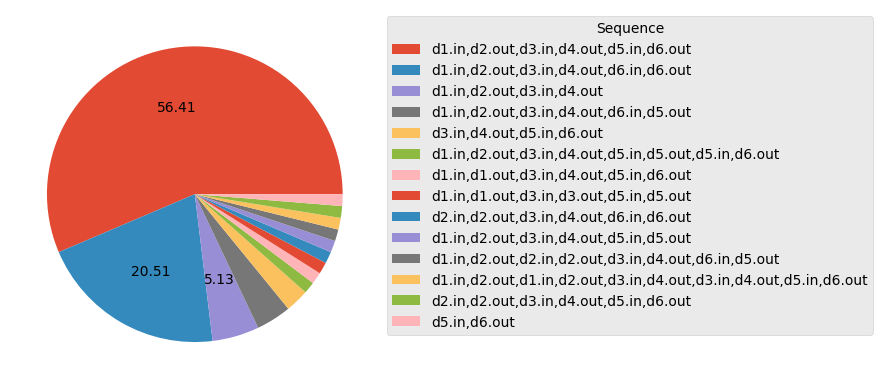

In [178]:
# pie chart representing the most frequent equences that occured

unique_sequences = filtered_doors_df['sequence'].value_counts()

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 4 else ''

plt.style.use('ggplot')

plt.pie(unique_sequences, autopct=my_autopct)

plt.legend(unique_sequences.index, title="Sequence", loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("pie_chart.png")
plt.show()


# traffic flow

In [179]:
# snakey plot representing the flow of traffic through doors

original_doors = sorted(set([door for seq in filtered_doors_df['sequence'] for door in seq.split(',')]))

desired_doors = ['cube1_entrance', 'cube1_entrance', 'cube1_exit', 'cube1_exit', 'cube2_entrance', 'cube2_entrance', 'cube2_exit', 'cube3_entrance', 'cube3_entrance', 'cube3_exit', 'cube3_exit']

flow_matrix = pd.DataFrame(0, index=original_doors, columns=original_doors)

for sequence in filtered_doors_df['sequence']:
    doors_visited = sequence.split(',')
    for i in range(len(doors_visited) - 1):
        flow_matrix.loc[doors_visited[i], doors_visited[i + 1]] += 1

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=original_doors
    ),
    link=dict(
        arrowlen=15,
        source=[original_doors.index(src) for src in flow_matrix.index for _ in range(len(flow_matrix.columns))],
        target=[original_doors.index(dest) for _ in range(len(flow_matrix.index)) for dest in flow_matrix.columns],
        value=flow_matrix.values.flatten()
    )
)])

fig.update_traces(
    node=dict(label=desired_doors),
    selector=dict(type='sankey')
)

fig.write_html("sankey_plot.html")

fig.show()


In [180]:
# snakey plot representing the flow of traffic through doors (this time with original door labels)

doors = sorted(set([door for seq in filtered_doors_df['sequence'] for door in seq.split(',')]))

flow_matrix = pd.DataFrame(0, index=doors, columns=doors)

for sequence in filtered_doors_df['sequence']:
    doors_visited = sequence.split(',')
    for i in range(len(doors_visited) - 1):
        flow_matrix.loc[doors_visited[i], doors_visited[i + 1]] += 1
        
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=doors
    ),
    link=dict(
        arrowlen=15,
        source=[doors.index(src) for src in flow_matrix.index for _ in range(len(flow_matrix.columns))],
        target=[doors.index(dest) for _ in range(len(flow_matrix.index)) for dest in flow_matrix.columns],
        value=flow_matrix.values.flatten()
    )
)])


fig.show()


# impact of companionship on path choice

read questionnaire data

In [181]:
questionnaire_df = pd.read_csv("questionnaire_data.csv")

merge the two df s

In [182]:
merged_df = pd.merge(filtered_doors_df, questionnaire_df, left_on='wearer_name', right_on='Participant ID', how='left', indicator=True)

no_match_df = merged_df[merged_df['_merge'] == 'left_only']

num_no_match = len(no_match_df)
wearer_names_no_match = no_match_df['wearer_name'].tolist()

print(f"The number of rows in filtered_doors_df without a match in questionnaire_df: {num_no_match}")
print(f"The wearer names without a match: {wearer_names_no_match}")

The number of rows in filtered_doors_df without a match in questionnaire_df: 4
The wearer names without a match: ['D02-P050', 'D03-P051', 'D03-P061', 'P01-D052']


In [183]:
filtered_doors_df['wearer_name'] = filtered_doors_df['wearer_name'].replace('P01-D052', 'D01-P052')

In [184]:
merged_df = pd.merge(filtered_doors_df, questionnaire_df[['Participant ID', 'How many people accompanied you on this visit?']], left_on='wearer_name', right_on='Participant ID', how='left')

merged_df.drop('Participant ID', axis=1, inplace=True)

merged_df


,wearer_name,sequence,num_items,video_incomplete,How many people accompanied you on this visit?
0,D01-P041,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,3 ou mais pessoas
1,D01-P042,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,3 ou mais pessoas
2,D01-P043,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,2 pessoas
3,D01-P044,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,2 pessoas
4,D01-P045,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,Nenhuma
...,...,...,...,...,...
73,D05-P047,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,3 ou mais pessoas
74,D05-P048,"d5.in,d6.out",2,False,1 pessoa
75,D05-P049,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,1 pessoa
76,D05-P050,"d1.in,d2.out,d3.in,d4.out,d5.in,d6.out",6,False,3 ou mais pessoas


In [185]:
nan_count = merged_df['How many people accompanied you on this visit?'].isna().sum()

print(f"Number of NaN values in the specified column: {nan_count}")


Number of NaN values in the specified column: 4


group data by number of accompanies and create a snakey plot for each group

In [186]:
groups = merged_df['How many people accompanied you on this visit?'].unique()

original_doors = sorted(set([door for seq in merged_df['sequence'] for door in seq.split(',')]))
desired_doors = ['cube1_entrance', 'cube1_entrance', 'cube1_exit', 'cube1_exit', 'cube2_entrance', 'cube2_entrance', 'cube2_exit', 'cube3_entrance', 'cube3_entrance', 'cube3_exit', 'cube3_exit']

# Create a Sankey plot for each group
for group in groups:
    group_df = merged_df[merged_df['How many people accompanied you on this visit?'] == group]

    flow_matrix = pd.DataFrame(0, index=original_doors, columns=original_doors)

    for sequence in group_df['sequence']:
        doors_visited = sequence.split(',')
        for i in range(len(doors_visited) - 1):
            flow_matrix.loc[doors_visited[i], doors_visited[i + 1]] += 1

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=original_doors
        ),
        link=dict(
            arrowlen=15,
            source=[original_doors.index(src) for src in flow_matrix.index for _ in range(len(flow_matrix.columns))],
            target=[original_doors.index(dest) for _ in range(len(flow_matrix.index)) for dest in flow_matrix.columns],
            value=flow_matrix.values.flatten()
        )
    )])

    fig.add_annotation(
        text=f"Group: {group}",
        x=0.1, y=1.1,
        showarrow=False,
        font=dict(size=14, color='black')
    )
    fig.update_traces(
        node=dict(label=desired_doors),
        selector=dict(type='sankey')
    )

    fig.write_html(f"sankey_plot_{group}.html")
    fig.show()


In [187]:
group_counts = merged_df['How many people accompanied you on this visit?'].value_counts()

print("Number of rows for each group:")
print(group_counts)


Number of rows for each group:
How many people accompanied you on this visit?
1 pessoa             32
3 ou mais pessoas    21
2 pessoas            15
Nenhuma               6
Name: count, dtype: int64
